In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!git clone https://github.com/fizyr/keras-retinanet.git
!pip install --upgrade keras
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace
!pip install gdown
!pip install tensorflow-gpu

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 5705 (delta 28), reused 38 (delta 15), pack-reused 5620
Receiving objects: 100% (5705/5705), 15.48 MiB | 30.65 MiB/s, done.
Resolving deltas: 100% (3791/3791), done.
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)
/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170899 sha256=415b4298977f79269e6a39c92dabfb11d8d10e93e90b3c9f31dd7a29ec7a0d59
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=47ffbe5d1d5042053bef6854fdf20488ae43d8b2ccf2c316231785875d460328
  Stored in directory: /root/.cache/pip/wheels/80/

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
os.chdir('/content')
!unzip /content/drive/My\ Drive/bachelor_project2/retinanet_compatible.zip 
!rm -rf retinanet_compatible/test/bbox-imgs-test.csv 
!rm -rf retinanet_compatible/train/bbox-imgs-train.csv 
!cp /content/drive/My\ Drive/bachelor_project2/bbox-imgs-test.csv retinanet_compatible/test/
!cp /content/drive/My\ Drive/bachelor_project2/bbox-imgs-train.csv retinanet_compatible/train/

Streaming output truncated to the last 5000 lines.
  inflating: retinanet_compatible/train/images/2016_0004812.jpg  
  inflating: retinanet_compatible/train/images/2016_0004813.jpg  
  inflating: retinanet_compatible/train/images/2016_0004814.jpg  
  inflating: retinanet_compatible/train/images/2016_0004815.jpg  
  inflating: retinanet_compatible/train/images/2016_0004816.jpg  
  inflating: retinanet_compatible/train/images/2016_0004817.jpg  
  inflating: retinanet_compatible/train/images/2016_0004818.jpg  
  inflating: retinanet_compatible/train/images/2016_0004819.jpg  
  inflating: retinanet_compatible/train/images/2016_000482.jpg  
  inflating: retinanet_compatible/train/images/2016_0004820.jpg  
  inflating: retinanet_compatible/train/images/2016_0004821.jpg  
  inflating: retinanet_compatible/train/images/2016_0004822.jpg  
  inflating: retinanet_compatible/train/images/2016_0004823.jpg  
  inflating: retinanet_compatible/train/images/2016_0004824.jpg  
  inflating: retinanet_com

In [0]:
df = pd.read_csv('retinanet_compatible/train/bbox-imgs-train.csv',header=None)
# dataset.head()
# df = pd.DataFrame(dataset)
# df = df.shift(1)
# df.iloc[0] =  df.columns
# df.head()
df.columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_name']
df['image_name'] = 'retinanet_compatible/train/images/' + df['image_name'].astype(str)
df.head()
df.to_csv('bbox-imgs-train.csv',index=False,header=False)


In [0]:
def show_image_objects(image_name,x_min, y_min,x_max, y_max):

  img_path = image_name
  box = [
    x_min, y_min, x_max, y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

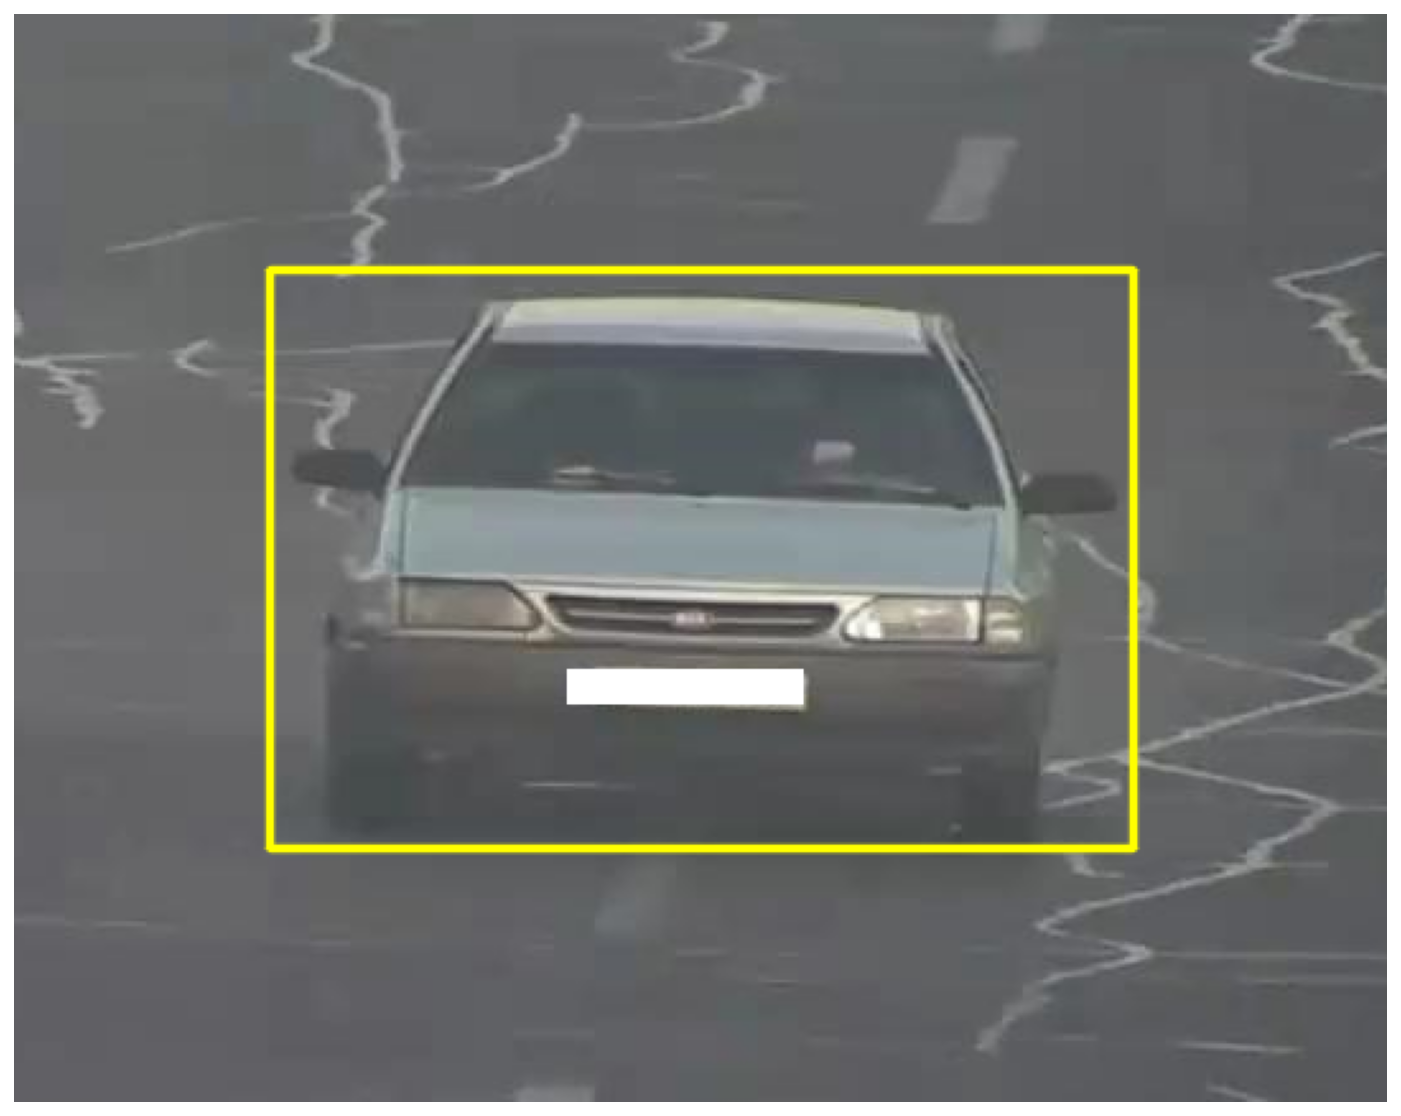

In [7]:
index = 5
show_image_objects(df.iloc[index][0],df.iloc[index][1],df.iloc[index][2],df.iloc[index][3],df.iloc[index][4])

# Training

In [8]:
PRETRAINED_MODEL = 'keras-retinanet/snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet101_oid_v1.0.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to keras-retinanet/snapshots/_pretrained_model.h5


In [0]:
!cp /content/drive/My\ Drive/bachelor_project2/new_class.csv class.csv

In [0]:
!keras-retinanet/keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 80 csv bbox-imgs-train.csv class.csv
# !keras-retinanet/keras_retinanet/bin/train.py --batch-size 8 --steps 100 --epochs 50 csv bbox-imgs-train.csv class.csv

Using TensorFlow backend.
2020-04-27 13:28:54.055089: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-27 13:28:54.055195: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-27 13:28:54.055213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Creating model, this may take a second...
2020-04-27 13:28:55.280303: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


# Loading the trained model

In [0]:
!ls snapshots

resnet50_csv_01.h5  resnet50_csv_04.h5	resnet50_csv_07.h5  resnet50_csv_10.h5
resnet50_csv_02.h5  resnet50_csv_05.h5	resnet50_csv_08.h5
resnet50_csv_03.h5  resnet50_csv_06.h5	resnet50_csv_09.h5


In [0]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv('class.csv', header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [

# Predictions

In [0]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [0]:
THRES_SCORE = 0.5

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)


In [0]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(255, 255, 0))

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [0]:
df_test = pd.read_csv('retinanet_compatible/test/bbox-imgs-test.csv',header=None)
# dataset.head()
# df = pd.DataFrame(dataset)
# df = df.shift(1)
# df.iloc[0] =  df.columns
# df.head()
df_test.columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_name']
df_test['image_name'] = 'retinanet_compatible/test/images/' + df_test['image_name'].astype(str)
df_test.head()
# df.to_csv('bbox-imgs-test.csv',index=False,header=False)


,image_name,x_min,y_min,x_max,y_max,class_name
0,retinanet_compatible/test/images/2016_0001029.jpg,100,100,541,372,rio
1,retinanet_compatible/test/images/2016_0001045.jpg,100,100,479,354,peugeot_206
2,retinanet_compatible/test/images/2016_0001047.jpg,100,82,437,329,zamyad_truck
3,retinanet_compatible/test/images/2016_0001050.jpg,100,100,447,343,pride_131
4,retinanet_compatible/test/images/2016_0001078.jpg,100,7,422,202,rio


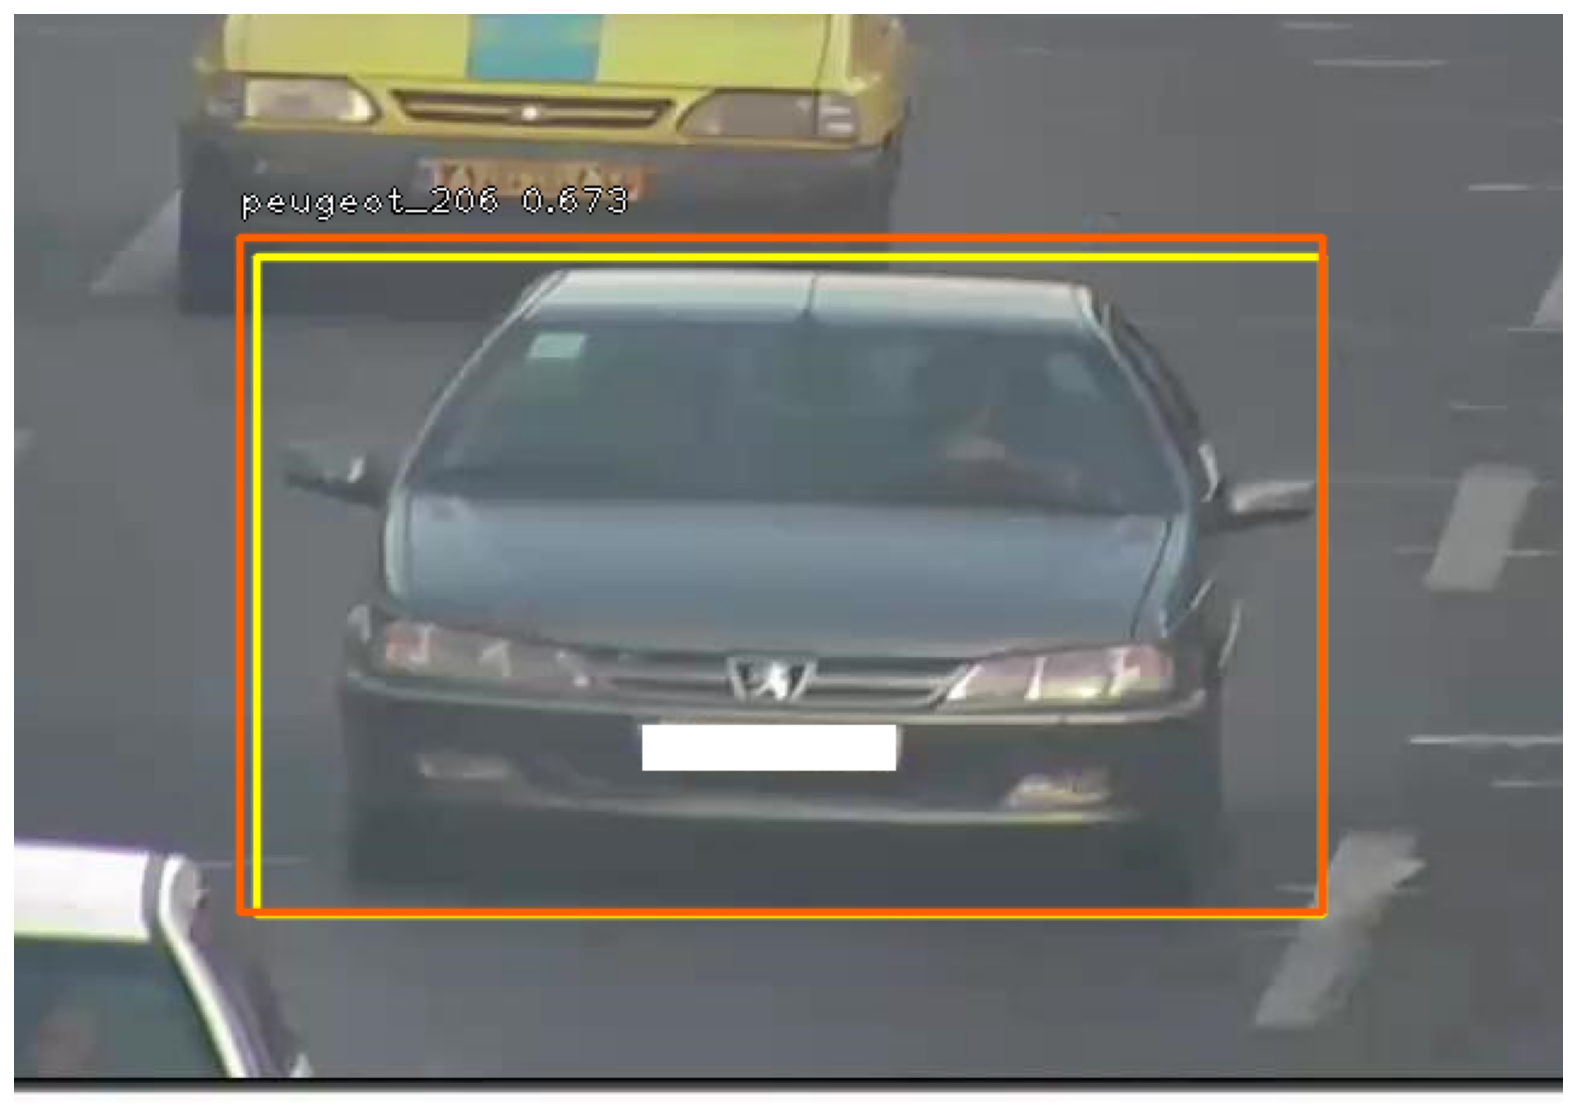

In [0]:
show_detected_objects(df_test.iloc[0])

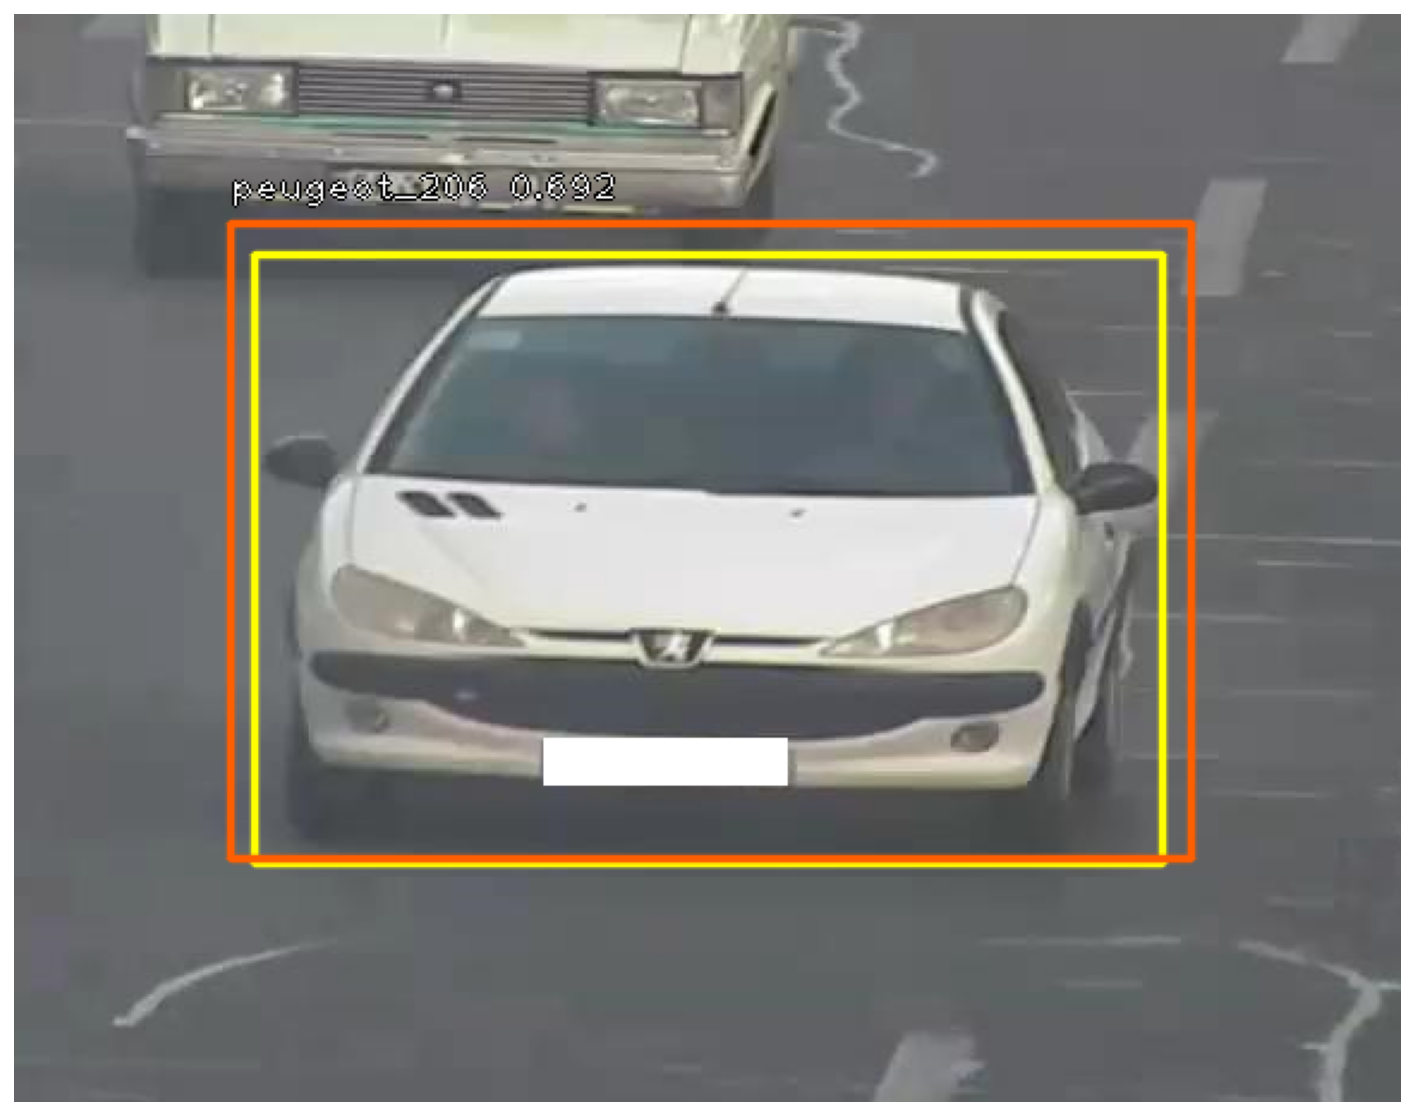

In [0]:
show_detected_objects(df_test.iloc[1])

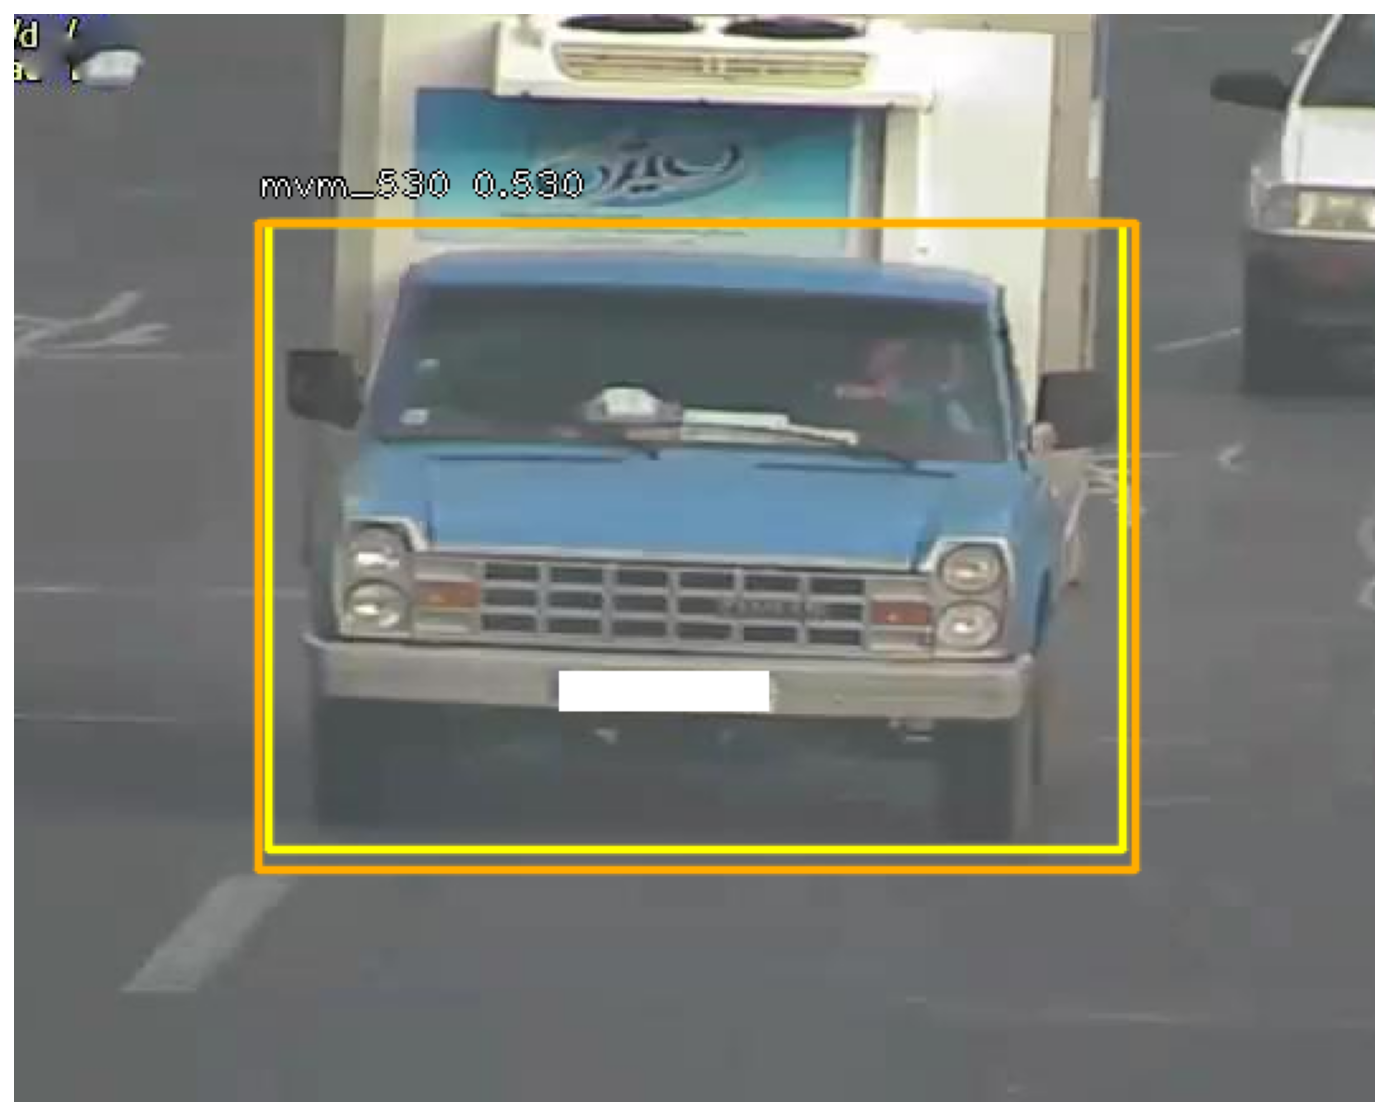

In [0]:
show_detected_objects(df_test.iloc[2])